# Clickbait Generator
Give me those clicks!!!
Data taken from https://github.com/bhargaviparanjape/clickbait

## Data Collection
1. Download source file
2. Extract archive

In [1]:
import os
import requests

In [2]:
data_file = "clickbait.gz"

def download_data():
    
    if os.path.exists(data_file):
        print("Found data file, not downloading")
        return
    
    print("Downloading data...")
    
    zip_file = requests.get("https://raw.githubusercontent.com/bhargaviparanjape/clickbait/master/dataset/clickbait_data.gz")

    with open(data_file, "wb+") as f:
        f.write(zip_file.content)
        

    

In [3]:
download_data()

Found data file, not downloading


## Data Processing
1. Extract archived data
2. Tokenize titles
3. Split into X and Y data

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import gzip
import numpy as np

vocab_size = 6000
sample_length = 10

In [5]:
def split_into_samples(titles):
    samples = []
    next_words = []
    
    for title in titles:
        
        if len(title) <= 2:
            continue

        samples.append(title[:-1])
        next_words.append(title[-1])
        
    return np.asarray(samples), np.asarray(next_words)

In [9]:
np.random.seed(0)

titles = []
with gzip.open(data_file, 'rt') as f:
    for line in f:
        if line != '\n':
            titles.append(line)
print(f"{len(titles)} total titles")

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(titles)
sequences = tokenizer.texts_to_sequences(titles)
count = 0
for s in sequences:
    if len(s) > 10:
        count += 1
        
print(f"count = {count}")
print(f"{len(tokenizer.word_index)} total words")
sequences = pad_sequences(sequences, maxlen=sample_length + 1) # add an extra 1 for the next word

X, Y = split_into_samples(sequences)
Y = to_categorical(Y, num_classes=vocab_size)


15999 total titles
count = 5642
12112 total words


## LSTM Model
Uses GloVe word embeddings

In [40]:
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.models import Model

In [43]:
def get_embedding_weights(tokenizer):
    # code based on Deep Learning with Python, 6.1.3
    glove_file = 'glove.6B.100d.txt'
    
    embedding_index = {}
    
    with open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0]
            embedding_index[word] = np.asarray(values[1:], dtype='float32')
            
    embedding_dim = 100 # should match glove filename
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    not_found = []
    
    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                not_found.append(word)
                
    print(f"Not found: {len(not_found)}\n{not_found}")
                
    return embedding_matrix

In [44]:
embedding_weights = get_embedding_weights(tokenizer)

Not found: 282
["here's", "you're", "it's", "you'll", "what's", "that'll", "you've", "don't", "didn't", "can't", "won't", "valentine's", "who's", "'00s", "aren't", "year's", "they're", "i'm", "there's", "adele's", 'selfie', "we're", 'emoji', "doesn't", "she's", "let's", "you'd", "isn't", "couldn't", "that's", "swift's", "we'll", 'emojis', "he's", "buzzfeed's", "victoria's", "india's", "mcdonald's", 'instagrams', "shouldn't", "bieber's", "everyone's", 'diys', "men's", "women's", "gaga's", 'snapchats', "jenner's", "haven't", "man's", "world's", "people's", "america's", "guy's", "kids'", "wouldn't", "grey's", "we've", 'kylo', 'delevingne', 'cringeworthy', "drake's", "kardashian's", "wasn't", "lawrence's", 'screencap', "woman's", "girl's", "bob's", "children's", "disney's", "styles'", "couple's", "girls'", "who've", "weren't", "2015's", "today's", 'selfies', "malik's", "they've", "santa's", "it'll", 'shamers', "freshers'", 'disick', "other's", "week's", 'boyega', "kid's", "canada's", 'shon

In [48]:
def create_model(sample_length, vocab_size, embedding_weights):
    input_layer = Input(shape=(sample_length,))
    
    m = Embedding(vocab_size, 100, input_length=sample_length)(input_layer)
    m = LSTM(128, dropout=0.5, return_sequences=True)(m)
    m = LSTM(128, dropout=0.5)(m)
    m = Dense(500, activation='relu')(m)
    m = Dropout(0.5)(m)
    m = Dense(vocab_size, activation='softmax')(m)
    
    model = Model(inputs=[input_layer], outputs=m)
    
    model.layers[1].set_weights([embedding_weights])
    model.layers[1].trainable = False
    
    return model

def make_plots(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    
    plt.show()

In [66]:
model = create_model(sample_length, vocab_size, embedding_weights)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 10, 100)           600000    
_________________________________________________________________
lstm_16 (LSTM)               (None, 10, 128)           117248    
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_15 (Dense)             (None, 500)               64500     
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 6000)              3006

In [67]:
history = model.fit(X, Y, batch_size=200, epochs=20, validation_split=0.05)

Train on 15199 samples, validate on 800 samples
Epoch 1/100
15199/15199 [==============================] - 8s 559us/sample - loss: 7.6088 - accuracy: 0.0303 - val_loss: 7.2773 - val_accuracy: 0.0275
Epoch 2/100
15199/15199 [==============================] - 6s 391us/sample - loss: 7.1079 - accuracy: 0.0331 - val_loss: 7.2472 - val_accuracy: 0.0275
Epoch 3/100
15199/15199 [==============================] - 6s 395us/sample - loss: 7.0217 - accuracy: 0.0327 - val_loss: 7.1994 - val_accuracy: 0.0275
Epoch 4/100
15199/15199 [==============================] - 6s 395us/sample - loss: 6.9713 - accuracy: 0.0345 - val_loss: 7.1276 - val_accuracy: 0.0300
Epoch 5/100
15199/15199 [==============================] - 6s 398us/sample - loss: 6.8889 - accuracy: 0.0484 - val_loss: 7.0408 - val_accuracy: 0.0700
Epoch 6/100
15199/15199 [==============================] - 6s 395us/sample - loss: 6.7329 - accuracy: 0.0642 - val_loss: 6.9179 - val_accuracy: 0.0862
Epoch 7/100
15199/15199 [=====================

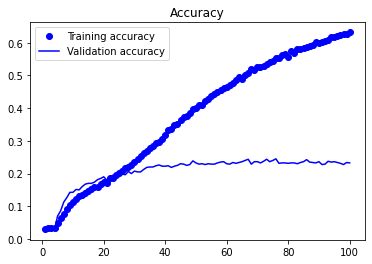

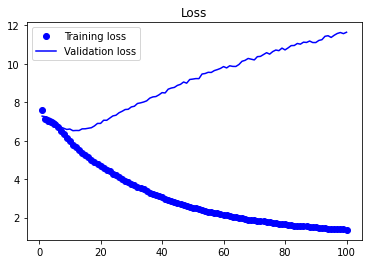

In [68]:
make_plots(history)

## Prediction

In [69]:
# temperature sampling based on Deep Learning book
def sample(preds, temperature):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probs = np.random.multinomial(1, preds, 1)
    return np.argmax(probs)

def generate_seq(model, tokenizer, seq_length, seed_text, n_words, temperature = 0.5):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        preds = model.predict(encoded, verbose=0)
        yhat = sample(preds[0], temperature)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [71]:
for i in range(0,10):
    output = generate_seq(model, tokenizer, sample_length, "", 6, 1)
    print(f"{i} {output}")

0 try pies reindeer nails test you
1  that disney words you actually
2 that a problems bear or you
3  block problems try spell a
4 try tinder forts mansion hacks flavors
5 that breakfast words you actually have
6  request princess 3 the leftovers
7 problems lovely of her costumes crush
8   problems try pies breakfast
9 request request school ladies of a
